In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [2]:
import numpy as np
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import time

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, stride=2),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class DoubleConvP(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, stride=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [4]:
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [5]:
class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=4, stride=2)
        self.conv = DoubleConvP(int(in_channels*1.5), out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [6]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
        self.f = nn.Tanh()

    def forward(self, x):
        x = self.conv(x)
        return self.f(x)

In [7]:
class GNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(GNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        #self.inc = nn.Conv2d(n_channels, 64, kernel_size=1)
        self.down1 = Down(3, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        factor = 1
        self.down4 = Down(256, 512 // factor)
        self.mid = DoubleConvP(512,512)
        self.up1 = Up(512, 256 // factor)
        self.up2 = Up(256, 128 // factor)
        self.up3 = Up(128, 64 // factor)
        self.up4 = Up(64, 32)
        self.outc = OutConv(32, n_classes)

    def forward(self, x):
        #x1 = self.inc(x)
        x1 = x
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x6 = self.mid(x5)
        x = self.up1(x6, x5)
        x = self.up2(x, x4)
        x = self.up3(x, x3)
        x = self.up4(x, x2)
        logits = self.outc(x)
        return logits

In [8]:
net = GNet(3,3)

In [9]:
data = torch.randn(16,3,256,256)
#data = torch.from_numpy(data)
print(data.shape)

torch.Size([16, 3, 256, 256])


In [10]:
out = net(data)

In [11]:
print(out.shape)

torch.Size([16, 3, 122, 122])


In [12]:

import fnmatch
train = []
tes = []

for root,dirs,files in os.walk('./new_data/liver/data_set'):
    if files:
        lst = os.listdir(root)
        png = fnmatch.filter(lst,'*.png')
        if png:
            for i in png:
                train.append((root+'/'+i))
for root,dirs,files in os.walk('./new_data/liver/test_set'):
      if files:
        lst = os.listdir(root)
        png = fnmatch.filter(lst,'*.png')
        if png:
            for i in png:
                tes.append((root+'/'+i))

In [13]:
trn = train 
test = tes

In [14]:
class MyDataset(Dataset):
    def __init__(self, image_path, transform = None, Label_trains = None):
        self.image_list = image_path
        self.len = len(self.image_list)
        self.transform = transform
        self.labeltrans = Label_trains
    def __getitem__(self, index):
        fn = self.image_list[index]
        img = Image.open(fn)
        label = img
        if self.transform is not None:
            img = self.transform(img) 
            label = self.labeltrans(label)
        return img, label
    def __len__(self):
        return self.len

Transform = transforms.Compose([
    #transforms.RandomRotation(degrees=90),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    #transforms.CenterCrop(224),
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])
Lable_trasfrom = transforms.Compose([
    transforms.Resize(122),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])

In [15]:
train_data = MyDataset(trn, transform = Transform, Label_trains=Lable_trasfrom)
test_data = MyDataset(test, transform = Transform, Label_trains=Lable_trasfrom)
train_loader = DataLoader(dataset=train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=32, shuffle=False)

In [16]:
for i,(data,label) in enumerate(train_loader):
    print(data.shape)
    print(label.shape)

torch.Size([32, 3, 256, 256])
torch.Size([32, 3, 122, 122])
torch.Size([32, 3, 256, 256])
torch.Size([32, 3, 122, 122])
torch.Size([32, 3, 256, 256])
torch.Size([32, 3, 122, 122])
torch.Size([32, 3, 256, 256])
torch.Size([32, 3, 122, 122])
torch.Size([32, 3, 256, 256])
torch.Size([32, 3, 122, 122])
torch.Size([32, 3, 256, 256])
torch.Size([32, 3, 122, 122])
torch.Size([32, 3, 256, 256])
torch.Size([32, 3, 122, 122])
torch.Size([32, 3, 256, 256])
torch.Size([32, 3, 122, 122])
torch.Size([32, 3, 256, 256])
torch.Size([32, 3, 122, 122])
torch.Size([32, 3, 256, 256])
torch.Size([32, 3, 122, 122])
torch.Size([32, 3, 256, 256])
torch.Size([32, 3, 122, 122])
torch.Size([32, 3, 256, 256])
torch.Size([32, 3, 122, 122])
torch.Size([32, 3, 256, 256])
torch.Size([32, 3, 122, 122])
torch.Size([27, 3, 256, 256])
torch.Size([27, 3, 122, 122])


In [17]:
import torchvision.models as models
from torch import nn,optim

net = net.to('cuda:0')
myloss = nn.L1Loss()
lr = 1e-1
history = []
optimizer = optim.SGD(net.parameters(),
                                lr=lr,
                                momentum=0.9,
                                weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1, last_epoch=-1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [18]:
for epoch in range(1000):
    epoch_start = time.time()
    print("Epoch: {}/{}".format(epoch+1, 1000))
    net.train()
    train_loss = 0.0
    valid_loss = 0.0
    train_acc = 0.0
    valid_acc = 0.0
    for i,(data,label) in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        outputs = net(data)
        loss = myloss(outputs,label)
        #loss = abs(loss-b) + b
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
    with torch.no_grad():
        net.eval()
        correct = list(0. for i in range(4))
        total = list(0. for i in range(4))
        #correct = list(0. for i in range(2))
        #total = list(0. for i in range(2))
        for j, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = net(inputs)
            loss = myloss(outputs, labels)
            valid_loss += loss.item() * inputs.size(0)
            
    avg_train_loss = train_loss/len(trn)
    avg_valid_loss = valid_loss/len(test)
    history.append([avg_train_loss, avg_valid_loss])
    epoch_end = time.time()
    torch.save(net.state_dict(),'./weight_auto/lastloss.pth')
    print("Epoch: {:03d}, Training: Loss: {:.4f}, \n\t\tValidation: Loss: {:.4f}, Time: {:.4f}s".format(epoch+1, avg_train_loss, avg_valid_loss, epoch_end-epoch_start))

Epoch: 1/1000
Epoch: 001, Training: Loss: 0.5991, 
		Validation: Loss: 0.5108, Time: 4.4692s
Epoch: 2/1000
Epoch: 002, Training: Loss: 0.4851, 
		Validation: Loss: 0.4858, Time: 4.2252s
Epoch: 3/1000
Epoch: 003, Training: Loss: 0.4687, 
		Validation: Loss: 0.4572, Time: 4.2283s
Epoch: 4/1000
Epoch: 004, Training: Loss: 0.4371, 
		Validation: Loss: 0.4531, Time: 4.2257s
Epoch: 5/1000
Epoch: 005, Training: Loss: 0.4540, 
		Validation: Loss: 0.4595, Time: 4.2362s
Epoch: 6/1000
Epoch: 006, Training: Loss: 0.4426, 
		Validation: Loss: 0.5162, Time: 4.2400s
Epoch: 7/1000
Epoch: 007, Training: Loss: 0.4438, 
		Validation: Loss: 0.5299, Time: 4.2446s
Epoch: 8/1000
Epoch: 008, Training: Loss: 0.4367, 
		Validation: Loss: 0.5085, Time: 4.2431s
Epoch: 9/1000
Epoch: 009, Training: Loss: 0.4264, 
		Validation: Loss: 0.4716, Time: 4.2477s
Epoch: 10/1000
Epoch: 010, Training: Loss: 0.4551, 
		Validation: Loss: 0.4254, Time: 4.2534s
Epoch: 11/1000
Epoch: 011, Training: Loss: 0.4386, 
		Validation: Los

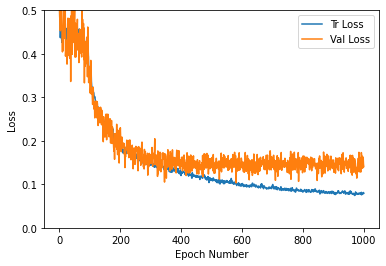

In [19]:
import matplotlib.pyplot as plt
history = np.array(history)
plt.plot(history[:, 0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0, 0.5)
plt.show()

In [20]:
import imageio
i = 0
for image, label in test_loader:
    image = image.to(device=device, dtype=torch.float32)
    label = label.to(device=device, dtype=torch.float32)
    pred = net(image)
    loss = myloss(pred,label)
    print(loss.item())
    pred = np.array(pred.data.cpu()[2])
    label = np.array(label.data.cpu()[2])
    pred = pred[0]
    label = label[0]
    #pred = pred.transpose(1,2,0)
    #label = label.transpose(1,2,0)
    imageio.imwrite('./res/' + str(i) + '.png', pred)
    imageio.imwrite('./res/' + str(i) + '_label.png', label)

Lossy conversion from float32 to uint8. Range [-1.0, 0.2844032943248749]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-1.0, 0.4274510145187378]. Convert image to uint8 prior to saving to suppress this warning.


0.14360257983207703
